In [1]:
import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt

### Load the impedance data (use only of dipolar kick)

- In accordance with Xavier's script: ../from 20Xavier/emitGrowth.py

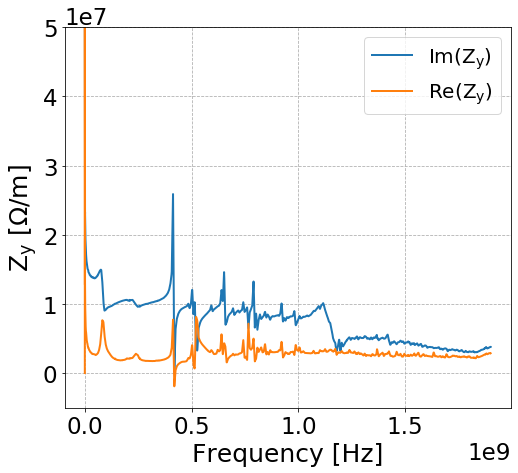

In [34]:
#### Impedance model from https://gitlab.cern.ch/IRIS/SPS_IW_model/-/tree/master/SPS_IW_model_python ###########################################
#impedanceData = np.genfromtxt('SPS_Complete_imp_model_2018_Q26.txt', skip_header=1, dtype=complex)
impedanceData = np.genfromtxt('./impedanceFiles/Q20/SPS_Complete_imp_model_2018_Q20.txt', skip_header=1, dtype=complex)


freqZ = np.real(impedanceData[:, 0]) * 1E9  # frequencies in [GHz], so probably this needs to change in 1e9
ReZ = np.real(impedanceData[:, 2])  # dipolar kick in y-plane, always odd, -f(x) = f(-x)
ImZ = np.imag(impedanceData[:, 2])  # dipolar kick in the y-plane, always even (f-x) = f(x)


# A1. Plot vertical impedances (dipolar kick only)
plt.plot(freqZ, ImZ, label=r'$\mathrm{Im(Z_y)}$')
plt.plot(freqZ, ReZ, label=r'$\mathrm{Re(Z_y)}$')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\mathrm{Z_y \ [\Omega /m]}$')
plt.legend()
plt.grid(ls='--')
plt.ylim(-0.5e7, 0.5e8)
plt.show()

### Plot again vs angular frequency

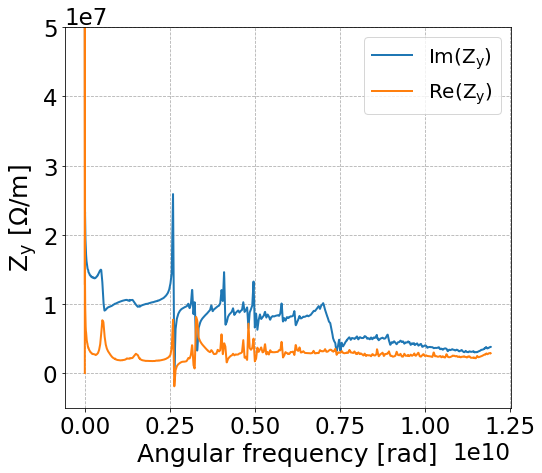

In [35]:
omegaZ = 2*np.pi*freqZ
# A2. Plot vertical impedances (dipolar kick only)
plt.plot(omegaZ, ImZ, label=r'$\mathrm{Im(Z_y)}$')
plt.plot(omegaZ, ReZ, label=r'$\mathrm{Re(Z_y)}$')
plt.xlabel('Angular frequency [rad]')
plt.ylabel(r'$\mathrm{Z_y \ [\Omega /m]}$')
plt.legend()
plt.grid(ls='--')
plt.ylim(-0.5e7, 0.5e8)
plt.show()
plt.close()

### Compute the effective impedance

The effective impedance $Z_{eff}$ is described by:

$Z_{\perp eff}^{(l)} = \frac{\sum_{p=-\infty}^{+ \infty}Z_{\perp }^{(l)}(\omega_{p}) h_l(\omega_{p}-\omega_\xi)}{\sum_{p=-\infty}^{+ \infty}h_l(\omega_{p}-\omega_\xi)}$ (1)

with $\omega_p = (p+Q)\omega_0$ the discrete spectrum of the transverse bunch oscillations. $-\infty < p < + \infty$ for a single bunch (which is our case) or several bunches oscillating independently. $\omega_\xi=(\xi \omega_0)/(\eta \nu_b)$ the chromatic frequency, with $\eta$ the phase slip factor. Note that $\xi$ is the chromaticity defined as $\xi = d\nu_b/d\delta$ with $\delta=\Delta P/P_0$ the relative momentum error, and $Q^\prime=\xi/\nu_b$. Thus we can re-write $\omega_\xi=Q^\prime \omega_0 / \eta$. \textbf{Attention:} In the simulations $Q^\prime$ is referred as chromaticity.

Last, $h_l$, is the power spectral density of a Gaussian bunch of $l$ azimuthial mode. $h_l$ is described by \cite{Chao:collective} (Chapter Eq.6.143):
$h_l(\omega) = (\omega \sigma_z/c)^{2l} e^{-(\omega \sigma_z/c)^2}$ (2)
   
where $c$ is the speed of light in [m/s].

In [36]:
def hmm_gaus(omega, sigma_z, clight, l=0):
    return (omega*sigma_z/clight)**(2*l)*np.exp(-(omega*sigma_z/clight)**2)

In [37]:
# create the spectrum with discrete lines
nSideband = 350000 #int(np.floor((1E10/(f_0))))
sidebands_p = np.arange(-nSideband, nSideband+0.5)

In [38]:
l = 0 # azimuthial mode (headtail mode)
clight = c*1e2 #[cm]/[s]
circum = 2 * np.pi * 1.1E3*1e2  # [cm]
f_0 = clight / circum  # revolution frequency in Hz
omega_0 = 2 * np.pi * f_0  # angular revolution frequency
Q_y = 26.18

In [39]:
omegas = omega_0*(sidebands_p+Q_y) # the middle is not zero due to the shift of q_y

In [40]:
### compute chromatic frequency shift

In [41]:
Qp_y_list = np.arange(0.0, 2.0, 0.2)#0.5 # chromaticity

gamma_t = 22.8  # for Q26

# Compute lorentz facotr
m0 = 0.9382720813e9 # proton rest mass, [eV/c^2]
E_rest = m0
E_0 = 270e9  # total energy of the reference particle [eV]
gamma = E_0/E_rest
eta = 1 / gamma_t ** 2 - 1 / gamma ** 2 # slip factor
omega_xi_list = Qp_y_list * omega_0 / eta

tau = 1.85e-9#2.1e-9 # 4 sigma_t [s]
sigma_z = 1e2*c*tau/4 #0.155  # [cm]
#sigma_z = 15.5
print(sigma_z)
#sigma_z = 27 #15.5 # [cm] 

13.8654011825


Text(0, 0.5, '$h_0(\\omega_p - \\omega_\\xi)$')

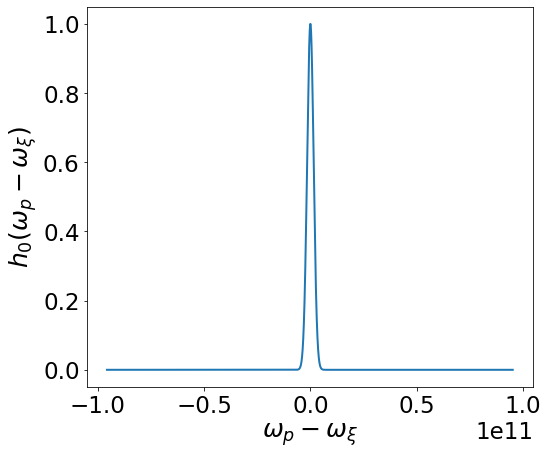

In [42]:
hs_list = []
for omega_xi in omega_xi_list:
    hs = hmm_gaus(omegas-omega_xi, sigma_z, clight=clight, l=0)
    #hs = hmm_gaus_tau(omegas-omega_xi, tau)
    hs_list.append(hs)
    
plt.plot(omegas-omega_xi, hs)
plt.xlabel(r'$\omega_p - \omega_\xi$')
plt.ylabel(r'$h_0(\omega_p - \omega_\xi)$')

In [43]:
### Create impedance for negative frequencies and Extrapolate Zeff in the omehas

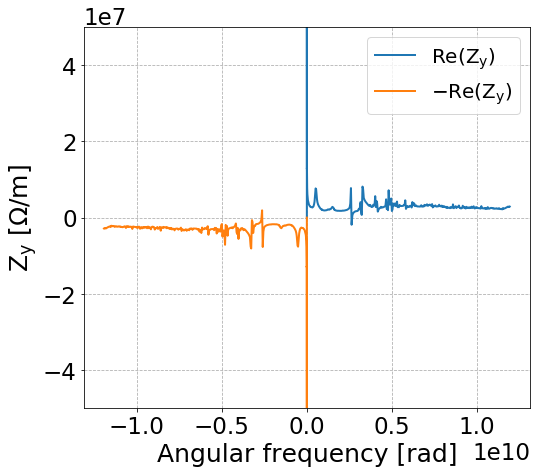

In [44]:
# You need to extrapolate Z eff in the omegas and also extend to negative frequencies
#zeffs_coherentDQ = np.interp(np.abs(omega_mp), omegaZ, ImZ)

# ReZ is always odd -f(x) = f(-x)
ReZ_pos = ReZ
ReZ_neg = -ReZ

# B. Plot vertical impedance also for negative frequencies
plt.plot(omegaZ, ReZ_pos, label=r'$\mathrm{Re(Z_y)}$')
plt.plot(-omegaZ, ReZ_neg, label=r'$\mathrm{-Re(Z_y)}$')

plt.xlabel('Angular frequency [rad]')
plt.ylabel(r'$\mathrm{Z_y \ [\Omega /m]}$')
plt.legend()
plt.grid(ls='--')
plt.ylim(-0.5e8, 0.5e8)
plt.show()
plt.close()

In [45]:
### Extrapolate

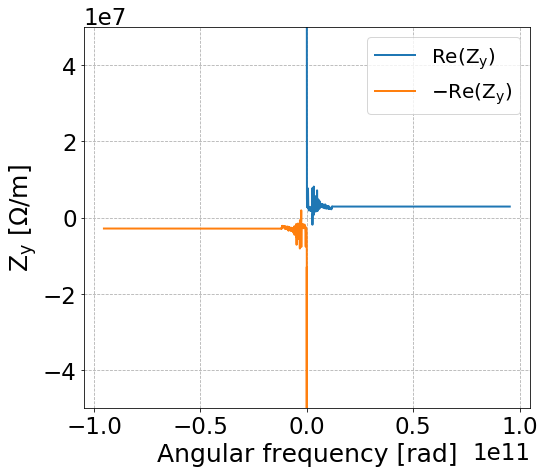

In [46]:
omegas_pos = list(filter(lambda x: x >=0, omegas))
omegas_neg = list(filter(lambda x: x < 0, omegas))

ReZ_pos_interp = np.interp(omegas_pos, omegaZ, ReZ_pos)
ReZ_neg_interp = np.interp(np.abs(omegas_neg), omegaZ, ReZ_neg)

# C1. Plot ImZ(my_omegas)
plt.plot(omegas_pos, ReZ_pos_interp, label=r'$\mathrm{Re(Z_y)}$')
plt.plot(omegas_neg, ReZ_neg_interp, label=r'$\mathrm{-Re(Z_y)}$')

plt.xlabel('Angular frequency [rad]')
plt.ylabel(r'$\mathrm{Z_y \ [\Omega /m]}$')
plt.legend()
plt.grid(ls='--')
plt.ylim(-0.5e8, 0.5e8)
plt.show()

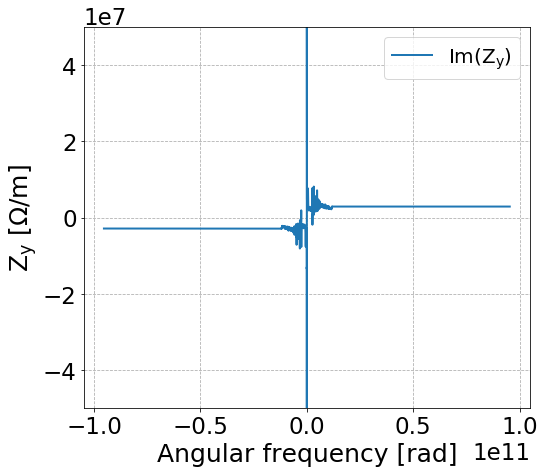

In [47]:
ReZ_interp_total = list(ReZ_neg_interp)+list(ReZ_pos_interp)

plt.plot(omegas, ReZ_interp_total, label=r'$\mathrm{Im(Z_y)}$')
plt.xlabel('Angular frequency [rad]')
plt.ylabel(r'$\mathrm{Z_y \ [\Omega /m]}$')
plt.legend()
plt.grid(ls='--')
plt.ylim(-0.5e8, 0.5e8)
plt.show()
plt.close()

In [48]:
Zeff_list = []
# compute effective impedance
for hs in hs_list:
    Zeff_nominator = np.sum(ReZ_interp_total*hs)
    Zeff_denominator = np.sum(hs)
    Zeff = Zeff_nominator/Zeff_denominator
    Zeff_list.append(Zeff)
    
print(f'Zeff = {Zeff_list} [Ohm/m]')

Zeff = [22817.96685879571, 59370.613698819696, 95903.99030279745, 132406.78576546648, 168867.72742496, 205275.59573809596, 241619.23903967201, 277887.5881524174, 314069.67081470584, 350154.62589363963] [Ohm/m]


### Convert in CGS units
- 1 [Ohm] = (1/9)*10**(-11) [s]/[cm]
- 1 [Ohm]/[m] = (1/9)*10**(-13) [s]/[cm]**2 

In [49]:
iZeff_cgs = np.array(Zeff_list)*(1/9)*1e-13 #[s]/[cm]**2 iZeff of Eq.6.207

### Compute DQ (CGS units)

\begin{equation}
\Omega^{(l)}-\omega_{\beta}-l\omega_s = -\frac{1}{4\pi}\frac{\Gamma(l+1/2)}{2^l l!}\frac{N r_0 c^2}{\gamma T_0 \omega_\beta \sigma} jZ_{eff} \ \ (4)
\end{equation}

For l = 0 :

- $(\Gamma(1/2)=\sqrt{\pi}$
- $T_0 = 2\pi/\omega_0$
- $Q_y = \omega_\beta/\omega_0$

\begin{equation}
\Omega^{(l)}-\omega_{\beta} = -\frac{\sqrt{\pi}}{4\pi}\frac{N r_0 c^2}{\gamma \frac{2\pi}{\omega_0} \omega_\beta \sigma} jZ_{eff}  \ \ (5)
\end{equation}

which is written:
\begin{equation}
\Delta\Omega = -\frac{N r_0 c^2}{8\pi^{3/2}\gamma Q_y \sigma} jZ_{eff}   \ \ (6)
\end{equation}

Last, 

\begin{equation}
\Delta Q = \frac{\Delta \Omega^{(l)}}{\omega_0} \ \ (7)
\end{equation}


In [50]:
# Compute DQ
r_0 = 1.535 * 10 ** (-16) # [cm]
Nb = 3.4e10 #intensity_list[4] #3e10  # protons per bunch

### Eq.6.207 Chao, collective effects
Domega = (Nb * r_0 * clight ** 2 * iZeff_cgs) / (8 * np.pi ** (3 / 2) * gamma * Q_y * sigma_z)

print(f'Delta Omega = {Domega}')

Delta Omega = [0.25557083 0.66497586 1.07416506 1.48301174 1.89138963 2.29917308
 2.70623718 3.11245796 3.51771252 3.9218792 ]


In [51]:
T_0 = 2*np.pi/omega_0
tau = -1/Domega/T_0 # https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.124402
growth  = 1/tau
print(f'rise time, tau={tau}') # tau in number of turns

print(f'growth rate = 1/tau = {growth}')

rise time, tau=[-169721.49930704  -65229.2321932   -40381.00535948  -29248.49752997
  -22933.3313444   -18865.8546209   -16028.10919282  -13936.20914184
  -12330.70209029  -11059.96968205]
growth rate = 1/tau = [-5.89200546e-06 -1.53305499e-05 -2.47641185e-05 -3.41897904e-05
 -4.36046549e-05 -5.30058150e-05 -6.23903910e-05 -7.17555248e-05
 -8.10983829e-05 -9.04161611e-05]


In [52]:
# Plotting parameters
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)
plt.close('all')

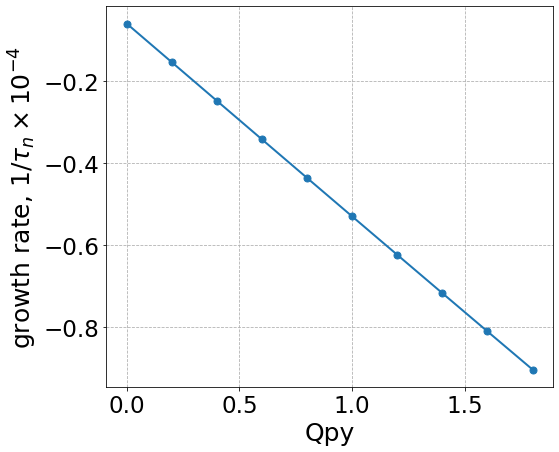

In [53]:
fig, ax = plt.subplots()

ax.plot(Qp_y_list, growth*1e4, 'o-')
ax.set_xlabel('Qpy')
ax.set_ylabel('growth rate, 1/'+r'$\tau_n \times 10^{-4}$')
ax.grid(ls='--')

Growth rate 1/τ = -3.0038671647740162e-06 


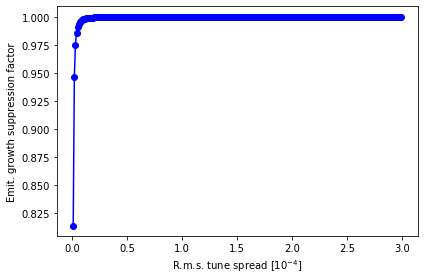

In [21]:
#growth = -Domega/omega_0
print(f'Growth rate 1/τ = {growth} ')
#DQ = -(beta*e*I_0*Zeff)/(4*sigma_z*np.sqrt(np.pi)*omega_0**2*gamma*26.18*m_p)

dGain = 2 * np.abs(growth)
dmu = np.arange(1E-6, 3E-4, 1E-6)  # tune spread (striclty from amplitude detuning)
supps = np.zeros_like(dmu)

    #### Eq. 26 in https://aip.scitation.org/doi/abs/10.1063/1.47298 ####################################

    #for i in range(len(dmu)):
    #    f = lambda x: (4 * np.pi ** 2 * (1 - dGain / 2) ** 2 * x ** 2) * np.exp(-x ** 2 / (2.0 * dmu[i] ** 2)) / (
    #                (4 * np.pi ** 2 * (1 - dGain / 2) * x ** 2 + (dGain / 2) ** 2) * np.sqrt(2 * np.pi) * dmu[i])
    #    integral = quad(f, -10 * dmu[i], 10 * dmu[i])
    #    supps[i] = integral[0]


for i in range(len(dmu)):
    supps[i] = (4*np.pi**2*(1-dGain/2)**2*dmu[i]**2)/(4*np.pi**2*(1-dGain/2)*dmu[i]**2+(dGain/2)**2)
##################################################################################################################################################

fig = plt.figure(1)
plt.plot(dmu * 1E4, supps, '-ob')
plt.xlabel(r'R.m.s. tune spread [$10^{-4}$]')
plt.ylabel(r'Emit. growth suppression factor')
plt.tight_layout()
plt.show()

save_supps = False
if save_supps:
    data = {'tune spread value': list(dmu), 'suppression factor':list(supps)}
    df = pd.DataFrame(data)
    print(df)
    filename = f'suppressionFactor_Intensity{Nb/1e10}e10_sigma_z{sigma_z}_Qpy{Qp_y}_dmuScan.pkl'
    if not os.path.exists(filename):
        df.to_pickle(filename)
